In [1]:
#Imports
import pandas as pd
import numpy as np
from numpy import array
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time
import keras
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import plot_model
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from sklearn import metrics
import math
import io
#import pylab as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
all_coords_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/all_coords_df.pkl')

In [4]:
all_coords_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293094 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 6 columns):
date         1293094 non-null datetime64[ns]
time         1293094 non-null object
longitude    1293094 non-null float64
latitude     1293094 non-null float64
y            1293094 non-null float64
x            1293094 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 69.1+ MB


In [5]:
all_coords_df.head()

,date,time,longitude,latitude,y,x
datetime,,,,,,
2019-04-16,2019-04-16,0:00,-73.98091,40.737885,586046.344512,4.510160e+06
2019-04-16,2019-04-16,0:00,-73.82261,40.762756,599375.548769,4.513088e+06
2019-04-16,2019-04-16,0:00,-73.82282,40.729404,599407.480337,4.509385e+06
2019-04-16,2019-04-16,0:00,-73.75374,40.665485,605341.759287,4.502370e+06
2019-04-16,2019-04-16,0:00,-73.95117,40.810173,588461.524222,4.518214e+06


In [6]:

#Determining limits of data
ymin = all_coords_df.y.min()
ymax = all_coords_df.y.max()
yrange = (ymax - ymin) / 65 #ground distance of each square in histogam below
xmin = all_coords_df.x.min()
xmax = all_coords_df.x.max()
datemin = all_coords_df.date.min()
datemax = all_coords_df.date.max()
xrange = (xmax - xmin) / 65 #ground distance of each square in histogram below
print(f"The max and min values for y and x are: {ymin}, {ymax}, {xmin} and {xmax}")
print(f'One square represents: x: {xrange}, y: {yrange} meters')
print(f'Date range is from {datemin} to {datemax}')

The max and min values for y and x are: 563160.1705779731, 612885.3478294573, 4483412.260444801 and 4529666.189655863
One square represents: x: 711.5989109394069, y: 765.0027269459097 meters
Date range is from 2012-07-01 00:00:00 to 2019-04-16 00:00:00


Below we will define the size of the histogram by ucreating two arrays containing the bins defined by taking the extreme values of lat and long and dividing them up evenly. WIll then fill in the accident data for the entire dataset as a test. Next step will want to be able to select the hour period.

In [7]:
#setting up 2D array. divide max and min values of coordinates into regular intervals
yedges = np.linspace(ymin, ymax, 65) #330
xedges = np.linspace(xmin, xmax, 65) #330

#generate the histogram using bins defined above
test_hist, yedges, xedges  = np.histogram2d(all_coords_df['y'], all_coords_df['x'], \
                                            bins=(yedges, xedges))
test_hist.shape, type(test_hist)
test_hist

array([[ 34., 186.,  77., ...,   0.,   0.,   0.],
       [117., 183., 221., ...,   0.,   0.,   0.],
       [ 11., 130., 272., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

Let's do some math: 365 days * 24 hours = 8760 2D rastors
I don't think for this project its feasable to do hourly rastors across the whole timeframe. Let's do last 6 months, leaving the last month as the test set?

min date = Dec 16 2018
max date = Apr 16 2019

1. nested loop for day and hour.
2. create a 2D histogram for all day and hour combinations. write to a numpy array
3. test case on 10 days

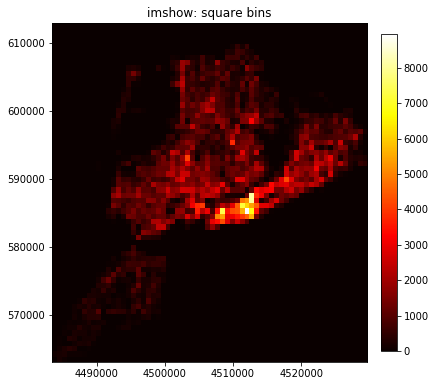

In [8]:
###Testing
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))
ax = fig.add_subplot(131, title='imshow: square bins')
_ = plt.imshow(test_hist, interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

***NOTE*** need to work out how to reverse the X-axis. Image is flipped horizontally/

In [9]:
len(all_coords_df.x), yedges

(1293094,
 array([563160.17057797, 563937.12647253, 564714.08236708, 565491.03826164,
        566267.99415619, 567044.95005075, 567821.9059453 , 568598.86183985,
        569375.81773441, 570152.77362896, 570929.72952352, 571706.68541807,
        572483.64131263, 573260.59720718, 574037.55310174, 574814.50899629,
        575591.46489084, 576368.4207854 , 577145.37667995, 577922.33257451,
        578699.28846906, 579476.24436362, 580253.20025817, 581030.15615273,
        581807.11204728, 582584.06794183, 583361.02383639, 584137.97973094,
        584914.9356255 , 585691.89152005, 586468.84741461, 587245.80330916,
        588022.75920372, 588799.71509827, 589576.67099282, 590353.62688738,
        591130.58278193, 591907.53867649, 592684.49457104, 593461.4504656 ,
        594238.40636015, 595015.36225471, 595792.31814926, 596569.27404381,
        597346.22993837, 598123.18583292, 598900.14172748, 599677.09762203,
        600454.05351659, 601231.00941114, 602007.9653057 , 602784.92120025,
  

In [10]:
#Trying to use datetime objects
# write a loop to select date and hour start with last 6 months
#get a list of each unique date
unique_date = np.unique(all_coords_df.date.dt.date) # return unique instances of just YYY-MM-DD
list_of_accidents = []
#loop over them
for i in pd.date_range(start='12-02-2018', end='4-16-2019', freq='H'):
    
# generate the individual histograms
    test_hist, yedges, xedges  = np.histogram2d(all_coords_df.loc[(all_coords_df.index >= i) & \
                                    (all_coords_df.index < (i + timedelta(hours=1)))].y, \
                                    all_coords_df.loc[(all_coords_df.index >= i) & \
                                    (all_coords_df.index < (i + timedelta(hours=1)))].x, bins=(yedges, xedges))
    list_of_accidents.append(test_hist)
    print(len(list_of_accidents))
    
#convert the list or arrays into a numpy array
array_of_accidents = np.array(list_of_accidents)
print('array shape:', array_of_accidents.shape)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
array_of_accidents_reshape = array_of_accidents.reshape(3241,64,64,1)

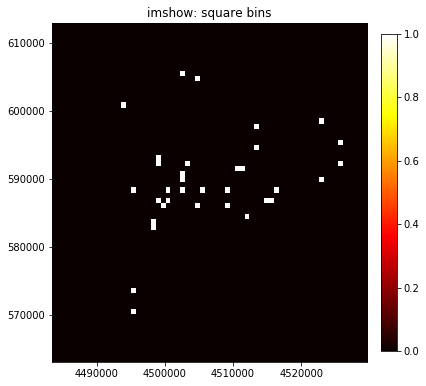

In [12]:
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))
ax = fig.add_subplot(131, title='imshow: square bins')
_ = plt.imshow(array_of_accidents[17], interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

In [13]:
array_of_accidents[5].sum()

13.0

## Feature Engineering

In [14]:
len(array_of_accidents)

3241

old index 0 1 2 3 4 5 6 7 8 9 10

new index - - - - - 0 1 2 3 4 5

Will lose 5 arrays due to the summing of 6 arrays. This means array length will reduce from 2905 to 2900

In [0]:
i=0
array_of_frequency = np.zeros(shape=(3236,64,64))
for i in range(3236):
        array_of_frequency[i] = (array_of_accidents[i] + array_of_accidents[i+1] + array_of_accidents[i+2] + array_of_accidents[i+3] + array_of_accidents[i+4] + array_of_accidents[i+5])/6

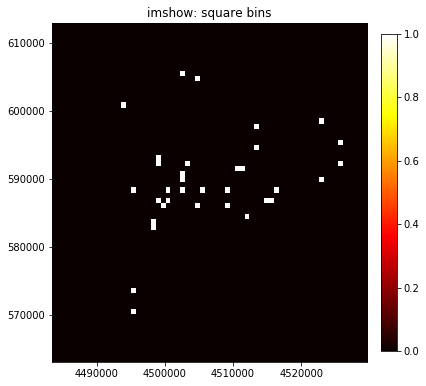

In [16]:
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))
ax = fig.add_subplot(131, title='imshow: square bins')
_ = plt.imshow(array_of_accidents[17], interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

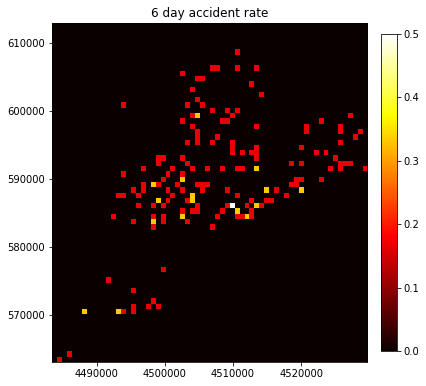

In [17]:
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))
ax = fig.add_subplot(131, title='6 day accident rate')
_ = plt.imshow(array_of_frequency[12], interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

In [0]:
array_of_frequency_reshape = array_of_frequency.reshape(3236,64,64,1)

In [0]:
#Turning this into a classification problem.
#Convert all non-zero entries into 1
binarize = True
if binarize:

  array_of_frequency_reshape[array_of_frequency_reshape > 0] = 1


In [20]:
#what are the dimensions?
print(array_of_frequency.shape, len(array_of_frequency) / 7) #how many time steps
#train, test, validate
# 70   :  20 :  10
#2265:647:324

#want approx 10% for test set. Choose 294
train_array = array_of_frequency_reshape[:2265]
test_array = array_of_frequency_reshape[2265:-324]
validate_array = array_of_frequency_reshape[-324:]

len(train_array), len(test_array), len(validate_array)

(3236, 64, 64) 462.2857142857143


(2265, 647, 324)

We want to create a 2D array for every hour. These will all go into a single array, so we can use a function to choose how

In [21]:
#Define a generator to select data using keras TimeseriesGenerator
# length - number of lag observations to use in the input for each sample
# batch_size - 

n_input = 6 # Want to train on 6 to predict 7th
train_generator = TimeseriesGenerator(train_array, train_array, length=n_input, batch_size=1) # 373 sets of 6 x 1 hour matrices - when set to 1, reproduces plot of all accidents
test_generator = TimeseriesGenerator(test_array, test_array, length=n_input, batch_size=1) # 42 sets of 6 x 1 hour matrices
validate_generator = TimeseriesGenerator(validate_array, validate_array, length=n_input, batch_size=1)
generator = TimeseriesGenerator(array_of_accidents, array_of_accidents, length=n_input, batch_size=1)
# number of samples
print('Length of train generator: %d' % len(train_generator))
print('Length of test generator:', len(test_generator))
print('Length of validate generator:', len(validate_generator))
# print each sample
for i in range(len(train_generator)):
    X, y = train_generator[i]
    #print('%s => %s' % (x, y))
print('check shape of arrays:', X.shape, y.shape) #what shape do X and y have 

Length of train generator: 2259
Length of test generator: 641
Length of validate generator: 318
check shape of arrays: (1, 6, 64, 64, 1) (1, 64, 64, 1)


I tried the three different ways, each using the same generator set up earlier. I think this is what I have to reshape, but I ahven't worked out how to yet...

# Model building

In [0]:
X, y = test_generator[27]

In [23]:
X.shape, y.shape

((1, 6, 64, 64, 1), (1, 64, 64, 1))

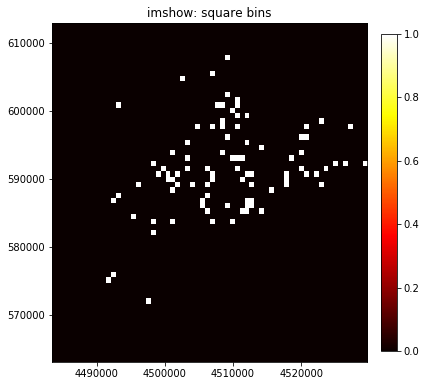

In [24]:
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))
ax = fig.add_subplot(131, title='imshow: square bins')
_ = plt.imshow(y.reshape(64,64), interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

In [25]:

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   input_shape=(None, 64, 64, 1),
                   padding='same', activation='relu', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   padding='same',  activation='relu',  return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   padding='same',  activation='relu',  return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   padding='same',  activation='relu',  return_sequences=False))
seq.add(BatchNormalization())

seq.add(Conv2D(filters=1, kernel_size=(5,5),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0000001), metrics=['binary_accuracy']) #loss='binary_crossentropy', optimizer='adadelta'
seq.summary()














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  819456    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 64, 64, 64)  819456    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 64, 64, 64)  256       
_____________

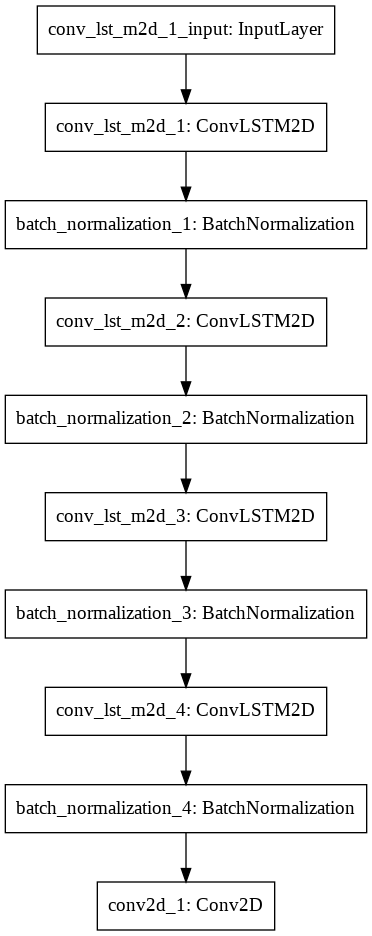

In [26]:

plot_model(seq, to_file='/content/drive/My Drive/Colab Notebooks/model_paper.png')

Model 2: changed 3,3 kernal to 5,5 and increased filters to 64

# Train the model

In [0]:

early_stopping_monitor = EarlyStopping(patience=2)
run_model = False   
if run_model:
    history_2_bin = seq.fit_generator(train_generator, epochs=50, validation_data=test_generator, callbacks=[early_stopping_monitor]) #including accuracy for classification
#from keras.models import load_model
#seq2 = load_model('/content/drive/My Drive/Colab Notebooks/20121230_convLSTM2D_adam_0000001.h5')

In [0]:
save_model = False
if save_model:
    seq.save('/content/drive/My Drive/Colab Notebooks/final_model_bin.h5') #seq4, 2 layers, , dropout, 50 epochs activation='sigmoid' loss='binary_crossentropy' 
    print("Saved model to disk")


In [29]:
load_the_model = True
if load_the_model:
    seq = load_model('/content/drive/My Drive/Colab Notebooks/final_model_bin.h5')
    print('Loaded model from disk')



Loaded model from disk


In [0]:
save_weights = False
if save_weights:
    seq.save_weights('/content/drive/My Drive/Colab Notebooks/final_weights_bin.h5')
    #save history
    hist_df=pd.DataFrame.from_dict(history_2_bin.history)
    hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/final_history_bin.csv')

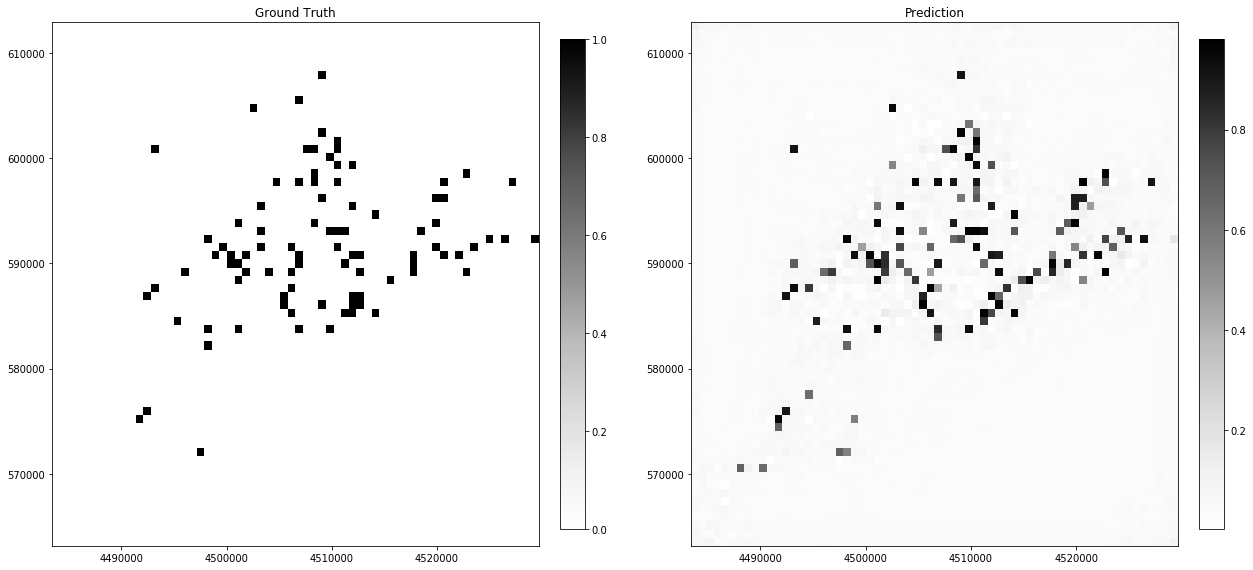

In [31]:
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))

plt.subplot(1,2,1)
plt.title('Ground Truth')
_ = plt.imshow(y.reshape(64,64), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.title('Prediction')
prediction = seq.predict(X)
#plot the histogram using np.imshow
_ = plt.imshow(prediction.reshape(64,64), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

In [32]:
history = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_history_bin.csv')
history.tail()

,Unnamed: 0,val_loss,val_binary_accuracy,loss,binary_accuracy
45,45,0.067440,0.991302,0.071283,0.991016
46,46,0.065774,0.991307,0.069793,0.991026
47,47,0.063595,0.991312,0.068364,0.991038
48,48,0.062976,0.991326,0.066988,0.991047
49,49,0.060914,0.991348,0.065659,0.991057


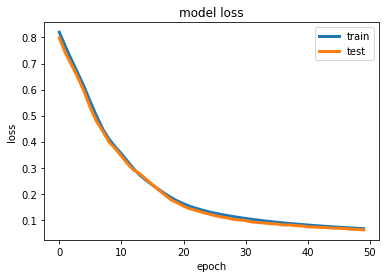

<Figure size 432x288 with 0 Axes>

In [33]:
# summarize history for loss
plt.plot(history['loss'], lw=3, )
plt.plot(history['val_loss'], lw=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/model_loss.png')

The output of the model is a probability. We need to stratify the results to either no increase in risk 0, or increase in risk 1. Do this by tranforming any value greater or equal to 0.5 to 1, the rest to 0.

In [0]:
test_df = pd.DataFrame(prediction.reshape(64,64))

In [35]:
test_df.sum() 

0     2.943326
1     2.445141
2     2.321620
3     2.191159
4     2.145100
        ...   
59    3.315576
60    3.257693
61    2.578573
62    2.778456
63    3.094653
Length: 64, dtype: float32

In [36]:
binary_test_df = test_df.copy()
binary_test_df[binary_test_df < 0.5] = 0 # any probability less than 0.5 becomes 0
binary_test_df[binary_test_df >= 0.5] = 1 # any probability greater than or equal to 0.5 becomes 1
binary_test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now only plot prediction values that have an accident rate greater than 0.5 and compare to ground truth

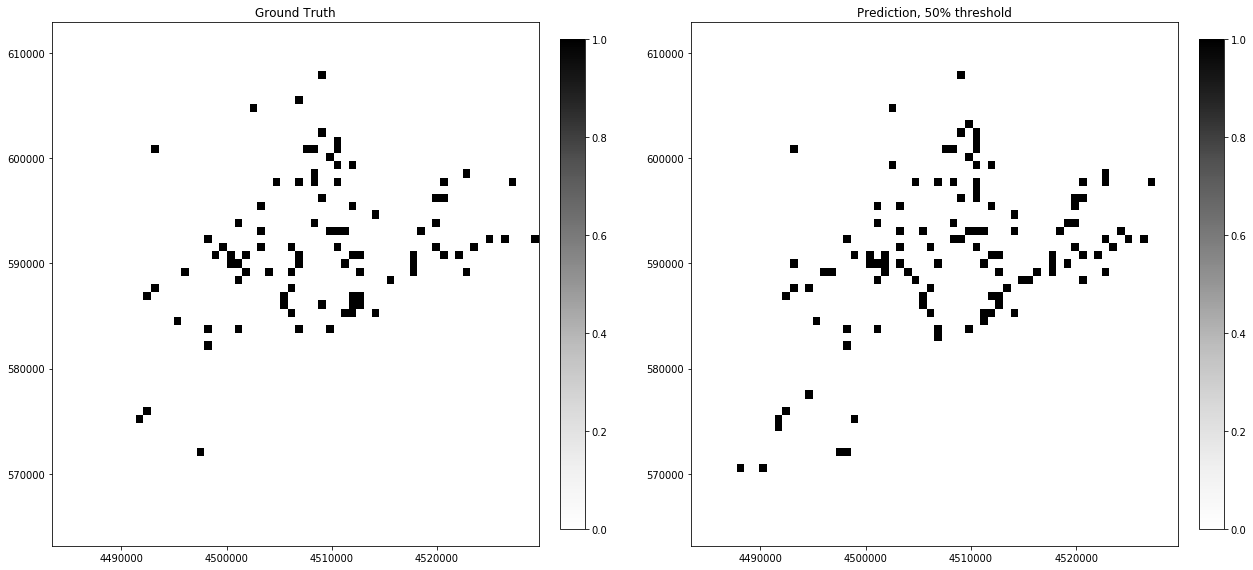

In [37]:
#plot the histogram using np.imshow
fig = plt.figure(figsize=(21, 21))

plt.subplot(1,2,1)
plt.title('Ground Truth')
_ = plt.imshow(y.reshape(64,64), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.title('Prediction, 50% threshold')
_ = plt.imshow(np.array(binary_test_df), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

In [0]:
#Compare the number of displayed cells between ground truth and prediction
#y.sum(), np.array(binary_test_df).sum()


# Confusion matrix
since prediction and ground truth are both in arrays,
multiply both together and sum: True positive
subtract ground truth from prediction
if +1 : false positive

if -1 : false negative
matrix size - TP -FP-FN : True negative
matthews correlation coefficient = 


Multiply arrays together. only coincident cells will remain 1, all else will be 0. This gives number of correctly predicted cells. Divide by sum of ground truth array will give percent predicted

In [38]:
pre_pred_array = np.array(binary_test_df) # convert df back to np array
pred_array = pre_pred_array.reshape(1,64,64,1) # reshape back to 4D to match y
score_array = pred_array * y
#score_array = y * np.array(binary_test_df)
y.sum(), np.array(binary_test_df).sum(), score_array.sum(), score_array.sum() / y.sum() * 100


(90.0, 116.0, 82.0, 91.11111111111111)

In [0]:
#create dataframe for ground truth and prediction
ground_truth_df = pd.DataFrame(y.reshape(64,64))
prediction_df = pd.DataFrame(seq.predict_classes(X).reshape(64,64))
product_df = ground_truth_df * prediction_df
difference_df = prediction_df - ground_truth_df

In [0]:
# ground truth
ground_truth = int(np.array(ground_truth_df.sum()).sum())
# true positive
true_pos = int(np.array(product_df).sum())
# false positive
false_pos = int((difference_df[difference_df == 1].sum()).sum())
# false negative
false_neg = int(abs((difference_df[difference_df == -1]).sum().sum()))
# true negative
true_neg = int((len(ground_truth_df) * len(ground_truth_df)) - true_pos - false_pos - false_neg)

In [0]:
# Matthew's correlation coefficient a value of 1 is perfect prediction, 0 is same as random chance
MCC = (true_pos * true_neg - false_pos * false_neg) / \
    math.sqrt((true_pos + false_pos)*(true_pos + false_neg)*(true_neg + false_pos)*(true_neg + false_neg))


In [42]:
print(f'Ground truth: {ground_truth}')
print(f'True positives: {true_pos}')
print(f'False positives: {false_pos}')
print(f'False negatives: {false_neg}')
print(f'True negatives: {true_neg}')
print(f'Matthew\'s correlation coefficient: {MCC}')

Ground truth: 90
True positives: 82
False positives: 34
False negatives: 8
True negatives: 3972
Matthew's correlation coefficient: 0.7976511531639582


In [0]:
model_confusion_df = pd.DataFrame(columns=['ground_truth', 'true_positive', 'false_positive', 'false_negative', 'true_negative'])
ground_truth_list = []
true_pos_list = []
false_pos_list = []
false_neg_list = []
true_neg_list = []

for i in train_generator:
    X, y = i

    #create dataframes for ground truth, prediction, the product and difference of the two
    ground_truth_df = pd.DataFrame(y.reshape(64,64))
    prediction_df = pd.DataFrame(seq.predict_classes(X).reshape(64,64))
    product_df = ground_truth_df * prediction_df
    difference_df = prediction_df - ground_truth_df

    # count ground truth
    ground_truth_list.append(int(np.array(ground_truth_df.sum()).sum()))
    # calc true positive
    true_pos_list.append(int(np.array(product_df).sum()))
    # calc false positive
    false_pos_list.append(int((difference_df[difference_df == 1].sum()).sum()))
    # calc false negative
    false_neg_list.append(int(abs((difference_df[difference_df == -1]).sum().sum())))
    # calc true negative
    true_neg_list.append(int((len(ground_truth_df) * len(ground_truth_df)) - \
        int(np.array(product_df).sum()) - \
        int((difference_df[difference_df == 1].sum()).sum()) - \
        int(abs((difference_df[difference_df == -1]).sum().sum()))))

#read lists into one dataframe    
model_confusion_df['ground_truth'] = ground_truth_list
model_confusion_df['true_positive'] = true_pos_list
model_confusion_df['false_positive'] = false_pos_list
model_confusion_df['false_negative'] = false_neg_list
model_confusion_df['true_negative'] = true_neg_list
        
    


In [0]:
# using apply function to create a new column: Matthew's correlation coefficient
# MCC = (TP*TN - FP*FN) / sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
model_confusion_df['Matthews_correlation'] = model_confusion_df.apply(lambda row: (row.true_positive * row.true_negative - \
                                            row.false_positive * row.false_negative) / math.sqrt((row.true_positive + \
                                            row.false_positive)*(row.true_positive + row.false_negative)*\
                                            (row.true_negative + row.false_positive)*(row.true_negative + \
                                                                                    row.false_negative)), axis = 1)

In [45]:
model_confusion_df.head(20)

,ground_truth,true_positive,false_positive,false_negative,true_negative,Matthews_correlation
0,83,54,11,29,4002,0.730454
1,90,73,8,17,3998,0.851925
2,102,80,9,22,3985,0.835872
3,122,91,10,31,3964,0.814871
4,132,109,12,23,3952,0.858124
5,152,120,10,32,3934,0.848561
6,157,125,23,32,3916,0.813087
7,162,139,14,23,3920,0.878234
8,163,137,18,26,3915,0.856344
9,158,132,27,26,3911,0.826082


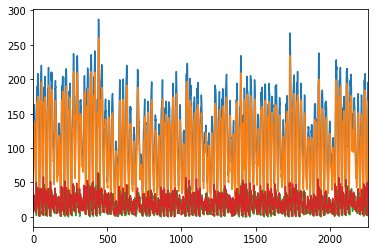

In [46]:
model_confusion_df.ground_truth.plot()
model_confusion_df.true_positive.plot()
model_confusion_df.false_positive.plot()
model_confusion_df.false_negative.plot()

Text(0.5, 1.0, "Matthew's correlation coefficient")

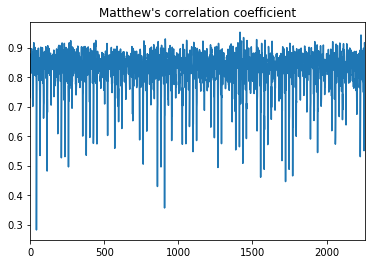

In [47]:
model_confusion_df.Matthews_correlation.plot()
plt.title('Matthew\'s correlation coefficient')

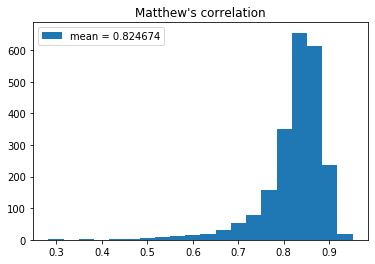

In [48]:
#plot a histogram of the Matthew's correlation coefficients
mcm = model_confusion_df.Matthews_correlation.mean()
_ = plt.hist(model_confusion_df.Matthews_correlation, bins=20)
_ = plt.legend(['mean = %f' % mcm], loc='upper left')
_ = plt.title('Matthew\'s correlation')